# Frame the Problem

**Problem**: The VP of Customer Advocacy has asked our team to evaluate how well we have been
supporting our customers over the last few quarters, and to provide meaningful business
insights.

**Why is Customer Service matter to the business ?**: 
A successful customer service team can help attract new business, boost retention, and increase sales among our existing customer base. But it is also a high stakes game:
- 73 % of consumers will leave for a competitor after multiple poor interactions 
- more than half will bolt after a single bad experience, according to the Zendesk Customer Experience Trends Report 2023. 
- Make it two negative experiences, and 76 percent of customers are out the door.

## Evaluate how well we have been supporting our customers

**What makes an excellent customer service ?**

Good customer service means consistently meeting customers’ expectations. Great customer service is **quick, easy, personalized, and empathetic**. Companies that deliver excellent customer service take the time needed to understand the needs of their unique customer base.

## Where can ML help ? 

By building a Satisfaction propensity model, we can identify what drives customer satisfaction. Possible use cases: 

1. Analyze Unsatisfied Tickets and understand where we can improve -> product, agent training, capacity. 
2. Prioritize tickets that have low satisfaction propensity score before it is closed. 

# Get Data


In [434]:
from google.cloud import bigquery
from google.oauth2 import service_account

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from random import randint

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings('ignore')

import re
import string

from scipy import stats
from scipy.stats import norm, skew #for some statistics

credentials = service_account.Credentials.from_service_account_file(
'/Users/joaolousada/Downloads/solar-vertex-380321-55f7948b7f6a.json') 

project_id = 'solar-vertex-380321'
client = bigquery.Client(credentials= credentials,project=project_id)

In [30]:
import pandas_gbq

sql = """
SELECT *
FROM solar-vertex-380321.zendesk.zentest
"""
df_raw = pandas_gbq.read_gbq(sql, project_id=project_id)

Downloading: 100%|██████████|


Data is imported from BigQuery and saved in df instance

In [344]:
df = df_raw.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240665 entries, 0 to 240664
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   EmployeeID            240665 non-null  Int64 
 1   TicketChannel         240665 non-null  object
 2   TicketGroup           240665 non-null  object
 3   TicketID              240665 non-null  Int64 
 4   TicketCreatedDate     240665 non-null  dbdate
 5   ZendeskPlan           177729 non-null  object
 6   DayTicketSolved       239741 non-null  object
 7   AssigneeTier          208010 non-null  object
 8   FirstReplyTime        157169 non-null  Int64 
 9   FullResolutionTime    239741 non-null  Int64 
 10  NumAgentComments      195237 non-null  Int64 
 11  NumPublicComments     192623 non-null  Int64 
 12  TicketEscalated       240665 non-null  Int64 
 13  CustomerSatisfaction  45554 non-null   Int64 
 14  WorkerDateHired       240665 non-null  dbdate
 15  WorkerLocation   

In [345]:
# remove null Customer Satisfcation values to evaluate if data distribution remains roughly the same 
df_csat = df[df['CustomerSatisfaction'].notnull()]

In [346]:
df.describe()

,EmployeeID,TicketID,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerTenure
count,240665.000000,2.406650e+05,157169.000000,239741.000000,195237.000000,192623.000000,240665.000000,45554.000000,240665.000000
mean,1853.958444,2.612557e+06,813.261088,5949.678053,3.100309,3.834443,0.159300,0.939500,514.366223
std,651.379958,2.820156e+05,6446.203622,19227.491206,3.499996,4.566357,0.365957,0.238413,353.778344
min,1.000000,2.116910e+06,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-223.000000
25%,1488.000000,2.340143e+06,14.000000,13.000000,1.000000,2.000000,0.000000,1.000000,262.000000
50%,1975.000000,2.629618e+06,53.000000,116.000000,2.000000,2.000000,0.000000,1.000000,469.000000
75%,2362.000000,2.849437e+06,236.000000,8112.000000,4.000000,4.000000,0.000000,1.000000,675.000000
max,3411.000000,3.224171e+06,498116.000000,548814.000000,370.000000,245.000000,1.000000,1.000000,2334.000000


In [347]:
df_csat.describe()

,EmployeeID,TicketID,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerTenure
count,45554.000000,4.555400e+04,35254.000000,45554.000000,37593.000000,40550.000000,45554.000000,45554.000000,45554.000000
mean,1879.801313,2.607657e+06,603.224485,5345.662554,3.335062,4.434772,0.193485,0.939500,498.598147
std,651.041433,2.828943e+05,2358.313163,15100.510555,3.652529,4.871586,0.395034,0.238413,346.220652
min,1.000000,2.116910e+06,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-80.000000
25%,1490.000000,2.333684e+06,18.000000,39.000000,1.000000,2.000000,0.000000,1.000000,240.000000
50%,2002.000000,2.625915e+06,63.000000,224.000000,2.000000,3.000000,0.000000,1.000000,456.000000
75%,2437.000000,2.846216e+06,238.000000,7165.750000,4.000000,6.000000,0.000000,1.000000,668.000000
max,3411.000000,3.090605e+06,221795.000000,508260.000000,149.000000,208.000000,1.000000,1.000000,2205.000000


In [348]:
df.describe(include= 'object')

,TicketChannel,TicketGroup,ZendeskPlan,DayTicketSolved,AssigneeTier,WorkerLocation,Worker_Type
count,240665,240665,177729,239741,208010,240665,240665
unique,9,29,14,7,4,11,2
top,chat,Support (T1),Enterprise Legacy,Wednesday,Tier 1,Madison,Employee
freq,87960,112207,44783,48229,155531,97997,240044


In [349]:
df_csat.describe(include= 'object')

,TicketChannel,TicketGroup,ZendeskPlan,DayTicketSolved,AssigneeTier,WorkerLocation,Worker_Type
count,45554,45554,36667,45554,40024,45554,45554
unique,7,27,14,7,4,11,2
top,chat,Support (T1),Enterprise Legacy,Wednesday,Tier 1,Madison,Employee
freq,19827,25023,10124,9636,30766,19114,45525


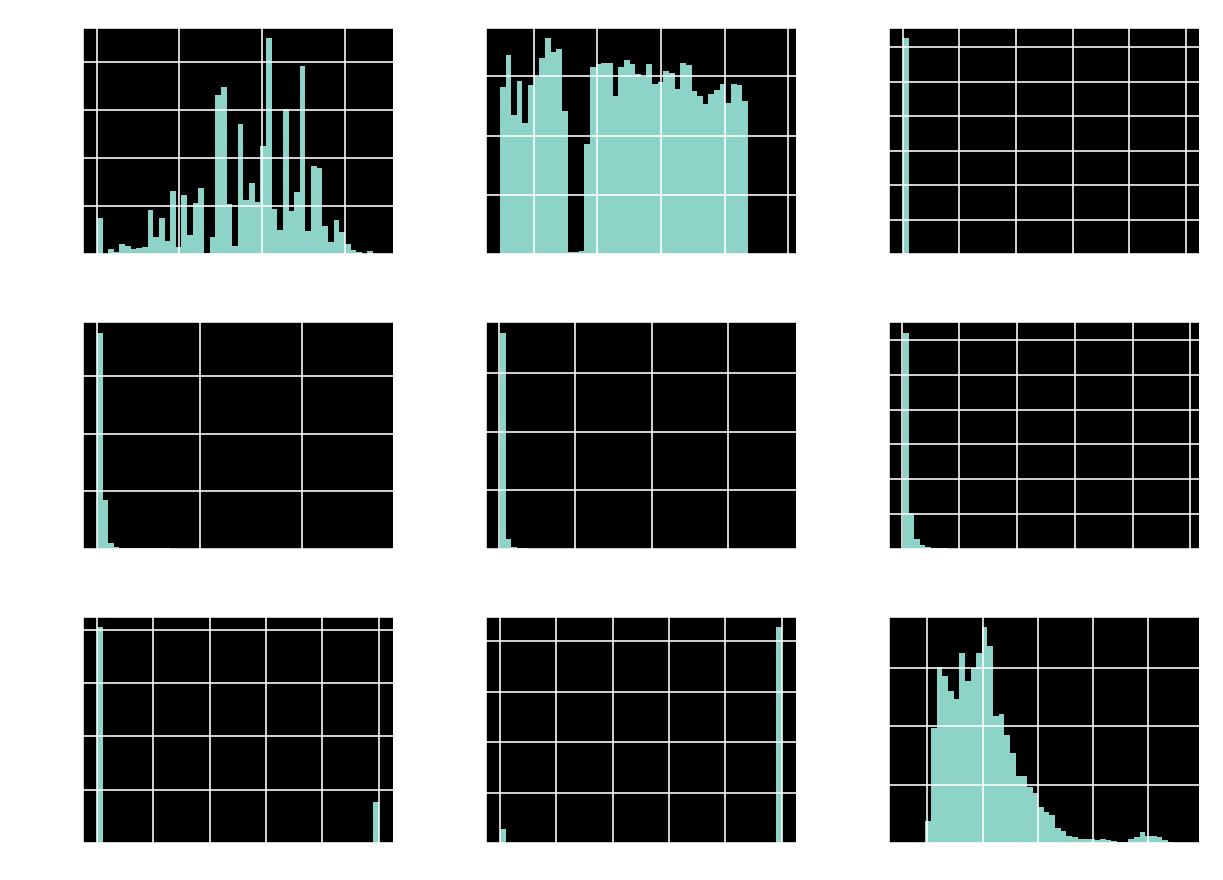

In [422]:
df.hist(bins=50, figsize=(20,15))
plt.show()

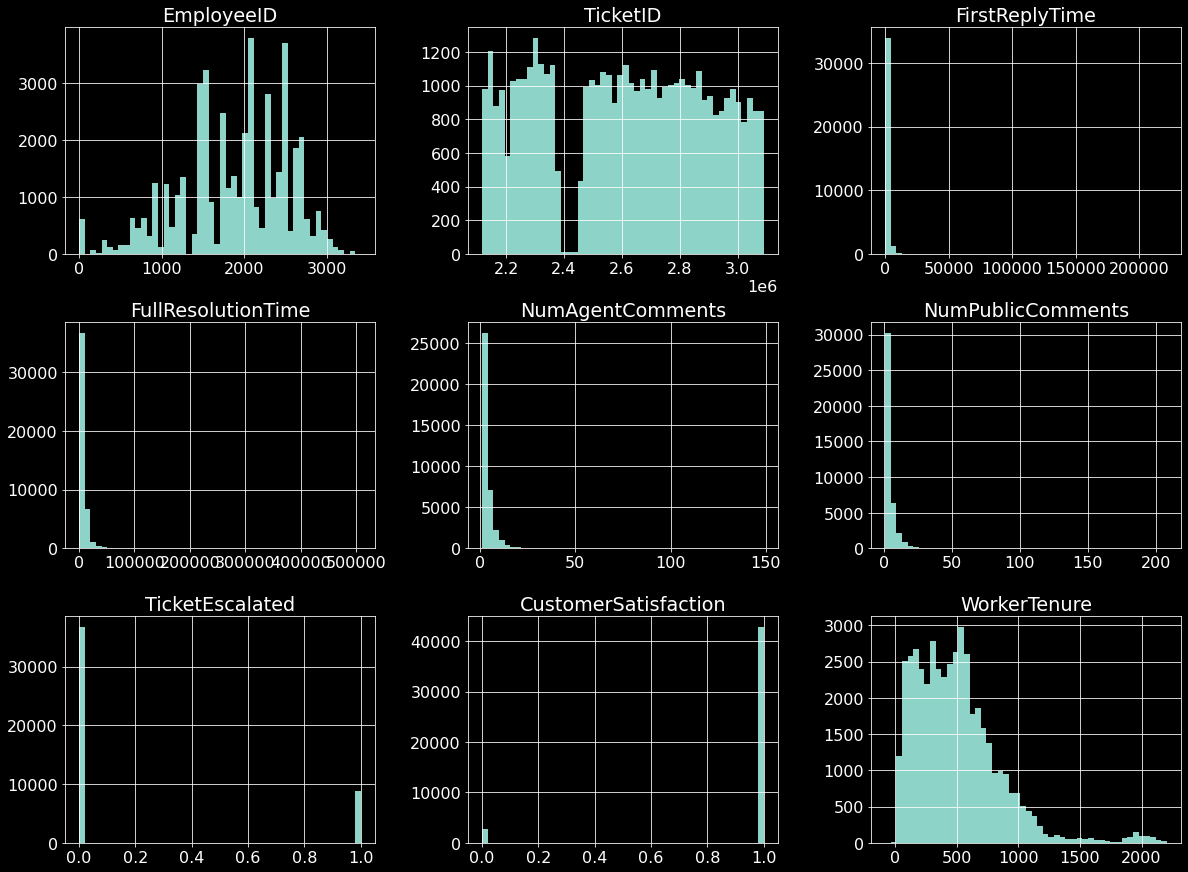

In [351]:
df_csat.hist(bins=50, figsize=(20,15))
plt.show()

There is no great loss of generality by dropping the dataset where CustomerSatisfaction is null. This part of the dataset can later be used for Semi-Supervised Learning.

In [352]:
missing = df_csat.isnull().sum()
missing = 100*missing[missing > 0]/df.shape[0]
missing.sort_values(inplace=True)
missing


NumPublicComments    2.079239
AssigneeTier         2.297800
NumAgentComments     3.307918
ZendeskPlan          3.692685
FirstReplyTime       4.279808
dtype: float64

In [353]:
# Drop open tickets 
df_csat = df_csat.dropna(subset=['FullResolutionTime', 'DayTicketSolved'])

for col in ('AssigneeTier', 'ZendeskPlan'):
    df_csat[col] = df_csat[col].fillna('None')

for col in ('NumPublicComments', 'NumAgentComments'):
    df_csat[col] = df_csat[col].fillna(0)

df_csat['FirstReplyTime'] = df_csat['FirstReplyTime'].fillna(0)

In [354]:
cols = ['FirstReplyTime', 'NumPublicComments', 'NumAgentComments', 'FullResolutionTime'] # one or more
df_csat

,EmployeeID,TicketChannel,TicketGroup,TicketID,TicketCreatedDate,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerDateHired,WorkerLocation,Worker_Type,WorkerTenure
924,688,chat,Zopim T1,2166897,2017-01-18,None,Friday,None,0,13309,1,0,0,0,2014-06-01,Manila,Employee,962
934,1463,chat,Zopim T1,2658930,2017-06-02,None,Friday,None,0,2,0,0,0,1,2015-08-03,Manila,Employee,669
936,1463,chat,Zopim T1,3060146,2017-10-20,None,Friday,None,0,10,0,0,0,1,2015-08-03,Manila,Employee,809
946,1463,chat,Zopim T1,2640859,2017-05-26,Plus,Friday,None,0,8,0,0,0,1,2015-08-03,Manila,Employee,662
948,1463,chat,Zopim T1,2978621,2017-09-22,None,Friday,None,0,15,0,0,0,1,2015-08-03,Manila,Employee,781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240649,1709,voice,Support (T1 English Phones),2241953,2017-02-07,Enterprise Legacy,Wednesday,Tier 1,23,11508,7,10,0,1,2015-11-16,Madison,Employee,449
240651,1855,voice,Support (T1 English Phones),2779256,2017-07-13,Plus,Wednesday,Tier 1,54,8291,7,10,0,1,2016-01-18,Dublin,Employee,542
240660,1731,voice,Support (T1 English Phones),2788461,2017-07-17,Plus,Wednesday,Tier 1,10,3104,11,12,0,1,2015-11-30,Madison,Employee,595
240661,2088,email,Support (T1 English Phones),2625975,2017-05-22,Plus,Wednesday,Tier 1,159,34175,16,12,1,1,2016-04-04,Melbourne,Employee,413


# EDA


We will use a log1p() function to make numerical variables have a more "normal" distribution. This function expands more frequent values and squeezes outliers

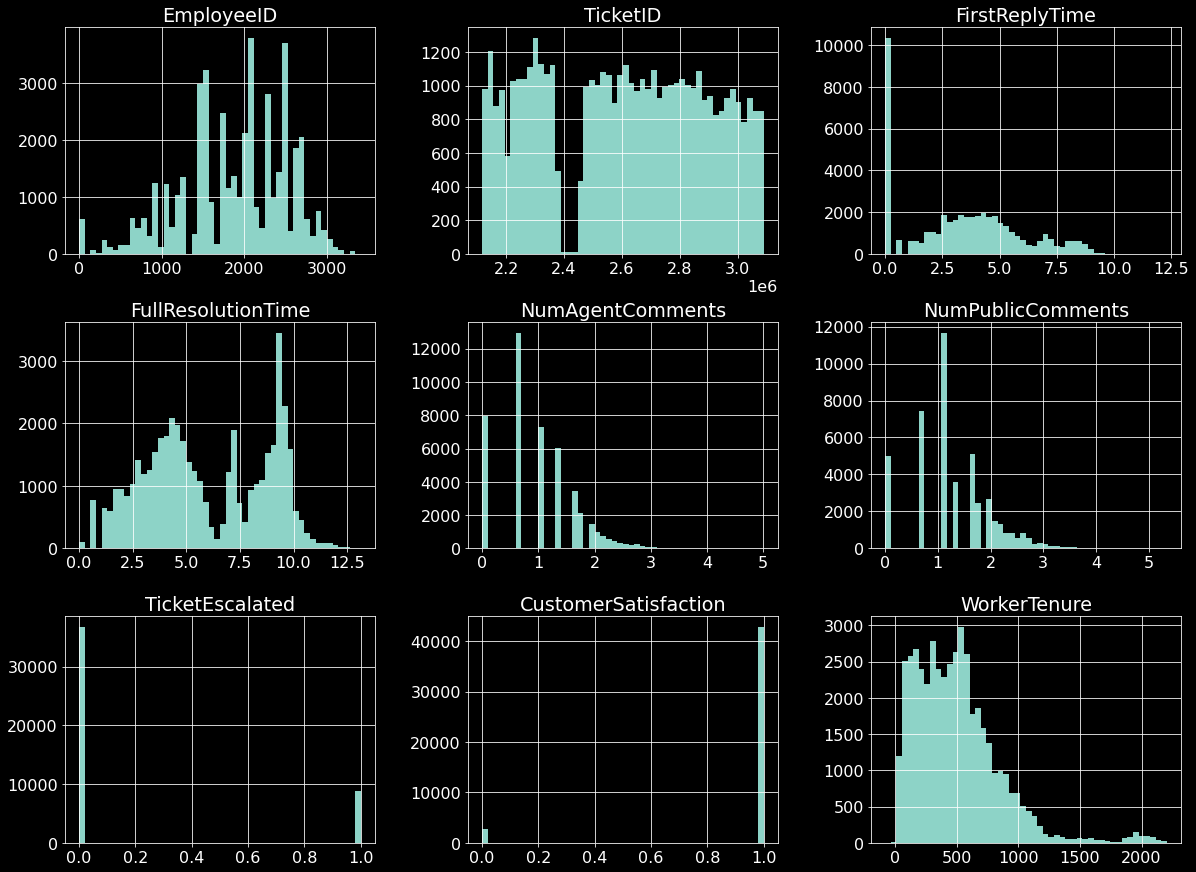

In [355]:
for c in cols: 
    df_csat[c] = np.log1p(df_csat[c])


df_csat.hist(bins=50, figsize=(20,15))
plt.show()

array([[<AxesSubplot:xlabel='FirstReplyTime', ylabel='FirstReplyTime'>,
        <AxesSubplot:xlabel='NumPublicComments', ylabel='FirstReplyTime'>,
        <AxesSubplot:xlabel='NumAgentComments', ylabel='FirstReplyTime'>,
        <AxesSubplot:xlabel='FullResolutionTime', ylabel='FirstReplyTime'>],
       [<AxesSubplot:xlabel='FirstReplyTime', ylabel='NumPublicComments'>,
        <AxesSubplot:xlabel='NumPublicComments', ylabel='NumPublicComments'>,
        <AxesSubplot:xlabel='NumAgentComments', ylabel='NumPublicComments'>,
        <AxesSubplot:xlabel='FullResolutionTime', ylabel='NumPublicComments'>],
       [<AxesSubplot:xlabel='FirstReplyTime', ylabel='NumAgentComments'>,
        <AxesSubplot:xlabel='NumPublicComments', ylabel='NumAgentComments'>,
        <AxesSubplot:xlabel='NumAgentComments', ylabel='NumAgentComments'>,
        <AxesSubplot:xlabel='FullResolutionTime', ylabel='NumAgentComments'>],
       [<AxesSubplot:xlabel='FirstReplyTime', ylabel='FullResolutionTime'>,
        <A

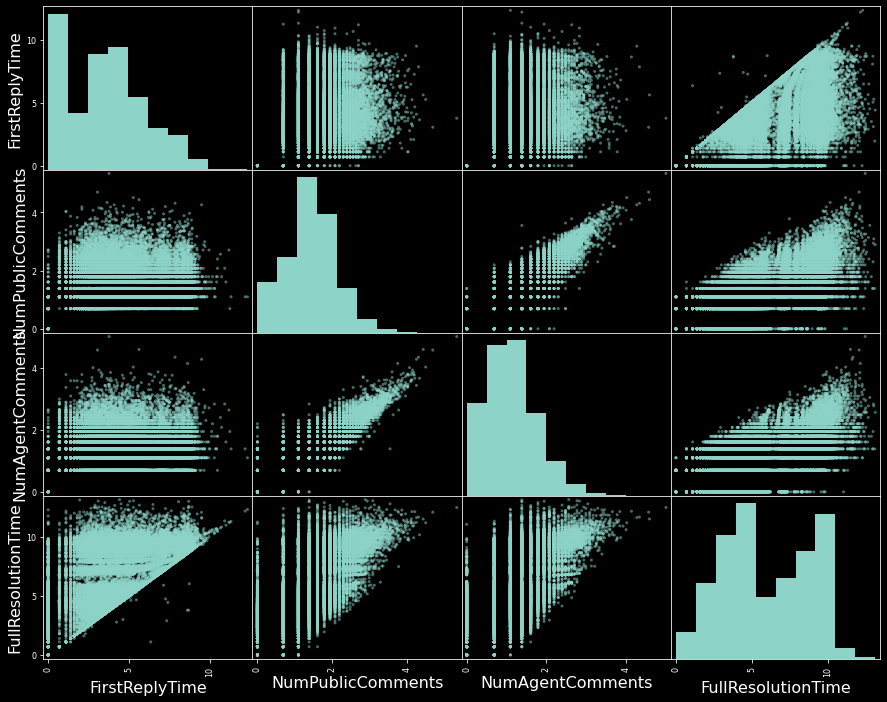

In [285]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_csat[cols],figsize=(15,12))


<AxesSubplot:xlabel='AssigneeTier', ylabel='Count'>

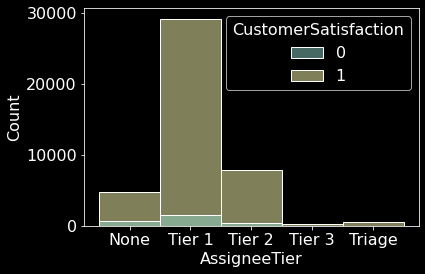

In [280]:
sns.histplot(data=df_csat, x='AssigneeTier', hue='CustomerSatisfaction')

<AxesSubplot:xlabel='NumAgentComments', ylabel='NumPublicComments'>

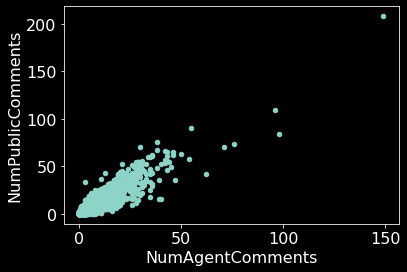

In [281]:
df_csat.plot(kind='scatter', x='NumAgentComments', y='NumPublicComments')

<AxesSubplot:xlabel='TicketChannel', ylabel='count'>

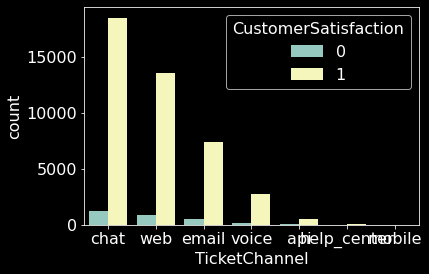

In [282]:
sns.countplot(data=df_csat, x='TicketChannel',hue='CustomerSatisfaction')

In [356]:
corr_matrix = df_csat.corr()
corr_matrix['CustomerSatisfaction'].sort_values(ascending=False)

CustomerSatisfaction    1.000000
EmployeeID              0.013534
NumPublicComments       0.007502
TicketEscalated         0.002854
TicketID               -0.009592
WorkerTenure           -0.015430
FirstReplyTime         -0.022942
NumAgentComments       -0.066787
FullResolutionTime     -0.132327
Name: CustomerSatisfaction, dtype: float64

There are no linear correlations in this dataset that could predict satisfaction. 

# Data Preparation

## Handle Categorical Attributes

In [357]:
df_csat.set_index('TicketID', inplace=True)

df_csat['TicketCreatedMonth'] = pd.DatetimeIndex(df_csat['TicketCreatedDate']).month
di = {'None': 0, 'Triage': 0, 'Tier 1': 1, 'Tier 2': 2, 'Tier 1': 3}
df_csat.replace({"AssigneeTier": di}, inplace=True)


In [358]:
from sklearn.preprocessing import LabelEncoder
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_attribs = df_csat.select_dtypes(include=numerics).columns

cat_attribs = df_csat.select_dtypes(include=object).columns
# process columns, apply LabelEncoder to categorical features
for c in cat_attribs:
    lbl = LabelEncoder() 
    lbl.fit(list(df_csat[c].values)) 
    df_csat[c] = lbl.transform(list(df_csat[c].values))
    
df_csat.head()

,EmployeeID,TicketChannel,TicketGroup,TicketCreatedDate,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerDateHired,WorkerLocation,Worker_Type,WorkerTenure,TicketCreatedMonth
TicketID,,,,,,,,,,,,,,,,,,
2166897,688,1,24,2017-01-18,7,0,0,0.0,9.496271,0.693147,0.0,0,0,2014-06-01,5,1,962,1
2658930,1463,1,24,2017-06-02,7,0,0,0.0,1.098612,0.0,0.0,0,1,2015-08-03,5,1,669,6
3060146,1463,1,24,2017-10-20,7,0,0,0.0,2.397895,0.0,0.0,0,1,2015-08-03,5,1,809,10
2640859,1463,1,24,2017-05-26,8,0,0,0.0,2.197225,0.0,0.0,0,1,2015-08-03,5,1,662,5
2978621,1463,1,24,2017-09-22,7,0,0,0.0,2.772589,0.0,0.0,0,1,2015-08-03,5,1,781,9


In [359]:
exclude = [
    'WorkerDateHired',
    'TicketCreatedDate'
]

df_base = df_csat.drop(exclude, axis=1)

df_base.head()

,EmployeeID,TicketChannel,TicketGroup,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerLocation,Worker_Type,WorkerTenure,TicketCreatedMonth
TicketID,,,,,,,,,,,,,,,,
2166897,688,1,24,7,0,0,0.0,9.496271,0.693147,0.0,0,0,5,1,962,1
2658930,1463,1,24,7,0,0,0.0,1.098612,0.0,0.0,0,1,5,1,669,6
3060146,1463,1,24,7,0,0,0.0,2.397895,0.0,0.0,0,1,5,1,809,10
2640859,1463,1,24,8,0,0,0.0,2.197225,0.0,0.0,0,1,5,1,662,5
2978621,1463,1,24,7,0,0,0.0,2.772589,0.0,0.0,0,1,5,1,781,9


# Train Model

In [313]:
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import optuna

cv = KFold(n_splits=10)

In [361]:
y = df_base.pop('CustomerSatisfaction')
X = df_base
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [362]:
from collections import Counter

y.value_counts(normalize=True)

1    0.9395
0    0.0605
Name: CustomerSatisfaction, dtype: Float64

In [363]:
def baseline(train, test, target, model): 
    cv = KFold(n_splits=5)
    
    score = cross_val_score(model, train, target, cv=cv, scoring="recall")
    print('score: %.3f' % score.mean())

    model.fit(train, target)
    predictions = model.predict(test)

    return predictions

In [364]:
lr = LogisticRegression(penalty='l2', class_weight='balanced')

y_pred = baseline(X_train, X_test, y_train, lr)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

score: 0.639
[[ 382  176]
 [3080 5473]]
Precision: 0.969
Recall: 0.640
F1: 0.771
Accuracy: 0.643


# Improvements

Created a Time Above Mean Feature that determines the time difference between Full Resolution Time and the mean resolution time for a particular Tier. 

It is expected that the higher the Tier, the longer a ticket will take to solve. If it takes to long to solve a "simple" ticket, there might be more reasons to negatively classify the support. And the same goes for positive classifications, if a complex ticket is solved quickly, customer will likely be satisfied. This is why we square the difference between ticket resolution time and median.

In [368]:
X = df_base

In [369]:
time_p_tier = X.groupby(['AssigneeTier'])['FullResolutionTime'].mean()

X['TimeAboveMean'] = X.apply(lambda x: np.power((x['FullResolutionTime'] - time_p_tier[x['AssigneeTier']]),2)/ time_p_tier[x['AssigneeTier']], axis=1)

In [370]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lr = LogisticRegression(penalty='l2', class_weight='balanced')

y_pred = baseline(X_train, X_test, y_train, lr)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

score: 0.711
[[ 360  198]
 [2440 6113]]
Precision: 0.969
Recall: 0.715
F1: 0.823
Accuracy: 0.710


Success ! we have mananged to increase our model metrics. 

Next feature we can build is related to Workload. Does the Agent workload impact the quality of his support ? to do this I constructed a feature that counts the size of an agent's queue at a particular point in time. 

To do this I build a MultiIndex data frame, where the first index is the employeeID and the second are all the unique dates in 2017. Then at any given date and per employee, I calculate how many tickets were opened and not yet closed. 

In [388]:
X = df_csat

X['TicketClosedDate'] = pd.to_datetime((pd.to_datetime(X['TicketCreatedDate']) + pd.to_timedelta(np.expm1(X['FullResolutionTime']), unit='m')).dt.date)
X['TicketCreatedDate'] = pd.to_datetime(X['TicketCreatedDate'])

def queue_size(eID, date): 
    mask = (date >= X['TicketCreatedDate']) & (date < X['TicketClosedDate'])
    return X[X['EmployeeID'] == eID].loc[mask].shape[0]

ts = pd.date_range(start=X['TicketCreatedDate'].min(), end=X['TicketClosedDate'].max())
eID = (list(X['EmployeeID'].unique()))

In [389]:
multi_index = pd.MultiIndex.from_product([eID,ts], names=["EmployeeID", "Date"]).to_frame()
multi_index.reset_index(drop=True, inplace=True)

# iterate through employees
multi_index['QueueSize'] = multi_index.apply(lambda x: queue_size(x['EmployeeID'], x['Date']), axis=1)
multi_index.set_index(['EmployeeID','Date'], inplace=True)

X['NrOpenTickets'] = X.apply(lambda x: multi_index.loc[x['EmployeeID'], x['TicketCreatedDate']], axis=1)
X.head()

,EmployeeID,TicketChannel,TicketGroup,TicketCreatedDate,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,...,TicketEscalated,CustomerSatisfaction,WorkerDateHired,WorkerLocation,Worker_Type,WorkerTenure,TicketCreatedMonth,TimeAboveMean,TicketClosedDate,NrOpenTickets
TicketID,,,,,,,,,,,,,,,,,,,,,
2166897,688,1,24,2017-01-18,7,0,0,0.0,9.496271,0.693147,...,0,0,2014-06-01,5,1,962,1,9.863099,2017-01-27,4
2658930,1463,1,24,2017-06-02,7,0,0,0.0,1.098612,0.0,...,0,1,2015-08-03,5,1,669,6,1.707082,2017-06-02,5
3060146,1463,1,24,2017-10-20,7,0,0,0.0,2.397895,0.0,...,0,1,2015-08-03,5,1,809,10,0.382540,2017-10-20,2
2640859,1463,1,24,2017-05-26,8,0,0,0.0,2.197225,0.0,...,0,1,2015-08-03,5,1,662,5,0.525286,2017-05-26,4
2978621,1463,1,24,2017-09-22,7,0,0,0.0,2.772589,0.0,...,0,1,2015-08-03,5,1,781,9,0.176461,2017-09-22,2


In [390]:
X.describe()

,EmployeeID,TicketChannel,TicketGroup,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerLocation,Worker_Type,WorkerTenure,TicketCreatedMonth,TimeAboveMean,NrOpenTickets
count,45554.000000,45554.000000,45554.000000,45554.000000,45554.000000,45554.000000,45554.000000,45554.000000,45554.000000,45554.000000,45554.000000,45554.000000,45554.000000,45554.000000,45554.000000,45554.000000,4.555400e+04,45554.000000
mean,1879.801313,3.000066,15.874808,7.050731,3.410085,1.556548,3.389724,5.949254,1.050033,1.306625,0.193485,0.939500,4.088730,0.999363,498.598147,5.276266,1.144920e+00,4.922180
std,651.041433,2.262158,4.756723,4.070385,2.200896,0.729573,2.523796,2.832550,0.708933,0.743699,0.395034,0.238413,1.925884,0.025223,346.220652,2.852633,1.429018e+00,3.763615
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-80.000000,1.000000,1.335567e-10,0.000000
25%,1490.000000,1.000000,14.000000,2.000000,1.000000,1.000000,1.098612,3.688879,0.693147,0.693147,0.000000,1.000000,2.000000,1.000000,240.000000,3.000000,2.195728e-01,2.000000
50%,2002.000000,2.000000,14.000000,7.000000,4.000000,2.000000,3.465736,5.416100,1.098612,1.098612,0.000000,1.000000,4.000000,1.000000,456.000000,5.000000,6.680596e-01,4.000000
75%,2437.000000,6.000000,21.000000,10.000000,5.000000,2.000000,5.003946,8.877208,1.386294,1.791759,0.000000,1.000000,5.000000,1.000000,668.000000,8.000000,1.719695e+00,7.000000
max,3411.000000,6.000000,26.000000,14.000000,6.000000,3.000000,12.309513,13.138750,5.010635,5.342334,1.000000,1.000000,10.000000,1.000000,2205.000000,10.000000,2.553080e+01,26.000000


In [391]:
exclude = [
    'WorkerDateHired',
    'TicketCreatedDate',
    'TicketClosedDate'
]

X = X.drop(exclude, axis=1)
X

,EmployeeID,TicketChannel,TicketGroup,ZendeskPlan,DayTicketSolved,AssigneeTier,FirstReplyTime,FullResolutionTime,NumAgentComments,NumPublicComments,TicketEscalated,CustomerSatisfaction,WorkerLocation,Worker_Type,WorkerTenure,TicketCreatedMonth,TimeAboveMean,TicketClosedDate,NrOpenTickets
TicketID,,,,,,,,,,,,,,,,,,,
2166897,688,1,24,7,0,0,0.0,9.496271,0.693147,0.0,0,0,5,1,962,1,9.863099,2017-01-27,4
2658930,1463,1,24,7,0,0,0.0,1.098612,0.0,0.0,0,1,5,1,669,6,1.707082,2017-06-02,5
3060146,1463,1,24,7,0,0,0.0,2.397895,0.0,0.0,0,1,5,1,809,10,0.382540,2017-10-20,2
2640859,1463,1,24,8,0,0,0.0,2.197225,0.0,0.0,0,1,5,1,662,5,0.525286,2017-05-26,4
2978621,1463,1,24,7,0,0,0.0,2.772589,0.0,0.0,0,1,5,1,781,9,0.176461,2017-09-22,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241953,1709,5,13,2,6,2,3.178054,9.350885,2.079442,2.397895,0,1,4,1,449,2,2.032195,2017-02-14,5
2779256,1855,5,13,8,6,2,4.007333,9.023046,2.079442,2.397895,0,1,2,1,542,7,1.665333,2017-07-18,2
2788461,1731,5,13,8,6,2,2.397895,8.040769,2.484907,2.564949,0,1,4,1,595,7,0.784586,2017-07-19,2


In [394]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lr = LogisticRegression(penalty='l2', class_weight='balanced')

y_pred = baseline(X_train, X_test, y_train, lr)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

score: 0.924
[[ 485   73]
 [ 656 7897]]
Precision: 0.991
Recall: 0.923
F1: 0.956
Accuracy: 0.920


We observe an increase in model metrics, approximating random model accuracy.

Random Forest Classifier

In [407]:
rf_params = {
    'max_depth': 12, 
    'min_samples_split': 4,
    'min_samples_leaf': 4,
    'max_features': 10,
    "n_estimators": 157
}

rf = RandomForestClassifier()
y_pred = baseline(X_train, X_test, y_train, rf)

score: 0.999


In [408]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

[[ 143  415]
 [  14 8539]]
Precision: 0.954
Recall: 0.998
F1: 0.975
Accuracy: 0.953


## Fine-Tuning

In [341]:
def objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 200)
    _max_depth = trial.suggest_int("max_depth", 5, 12)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 8)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 3, 6)
    _max_features = trial.suggest_int("max_features", 10, 50)

    rf = RandomForestClassifier(
     max_depth=_max_depth,
     min_samples_split=_min_samp_split,
     min_samples_leaf=_min_samples_leaf,
     max_features=_max_features,
     n_estimators=_n_estimators,
     n_jobs=-1,
     random_state=42,
    )

    score = cross_val_score(
     rf, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
    ).mean()
    return score


optuna.logging.set_verbosity(0)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

rf_params = study.best_params
rf_best_score = study.best_value
print(f"Best score:{rf_best_score} \nOptimized parameters: {rf_params}")

Best score:-0.21424119937976532 
Optimized parameters: {'n_estimators': 175, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 13}


In [342]:
rf_params = {
    'max_depth': 8, 
    'min_samples_split': 4,
    'min_samples_leaf': 4,
    'max_features': 13,
    "n_estimators": 175
}

rf = RandomForestClassifier()
y_pred = baseline(X_train, X_test, y_train, rf)

score: 0.998


In [343]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

[[ 147  411]
 [  13 8540]]
Precision: 0.954
Recall: 0.998
F1: 0.976
Accuracy: 0.953


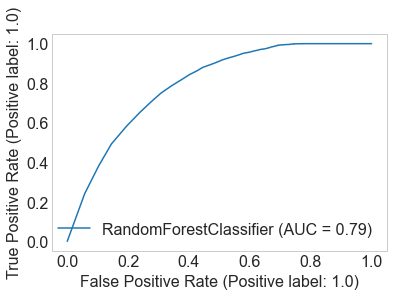

In [435]:
from sklearn.metrics import RocCurveDisplay

svc_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.show()

In [439]:
Counter(y_pred)

Counter({1.0: 8954, 0.0: 157})

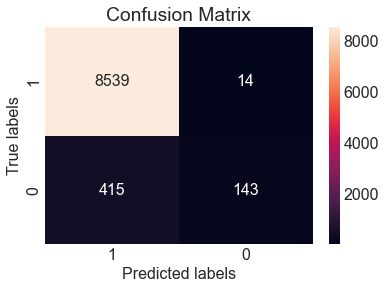

In [446]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred, labels=[1,0]), annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['1', '0']); ax.yaxis.set_ticklabels(['1', '0']);


The model performs really good, but is likely overfitting due to the lack of negative samples. 

Possible mitigation strategies: 
1. Bring human into the loop and ask agents to manually classify support tickets without label 
2. Make changes in the product to induce a higher response rate 
3. Collect data about ticket content, namely the content of the messages exchanged between agent/client 
4. Collecting what product area is the ticket related to. Some parts of the product may have higher friction/complexity that customers need support with.

In [465]:
X.plot.bar(x='sat')

KeyboardInterrupt: 